In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import explore as e
from importlib import reload
import wrangle as w
from scipy import stats


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.cluster import KMeans

In [35]:
reload(w)
df = w.wrangle_zillow(prop_row=.75,prop_col=.5,outlier_k=.0625)
df = df.dropna(subset=['calc_sqft','tax_value'])
train, validate, test = w.tvt_split(df)
# train.to_csv('data/prepared_zillow.csv')
df.isna().sum()

parcel_id                     0
bath_count                    0
bed_count                     0
calc_bath_and_bed             0
calc_sqft                     0
finished_sqft12            3626
fips                          0
fireplace_count               0
full_bath_count             603
garage_car_count              0
latitude                      0
longitude                     0
lot_sqft                      0
pool_count                    0
raw_census_tract_block        0
region_id_city             1465
region_id_county              0
region_id_zip                45
room_count                    0
unit_count                26812
year_built                  257
structure_tax_value         109
tax_value                     0
assessment_year               0
land_value                    2
tax_amount                    5
census_tract_and_block      238
log_error                     0
transaction_date              0
heating_system_desc       27935
property_land_use_desc     3286
dtype: i

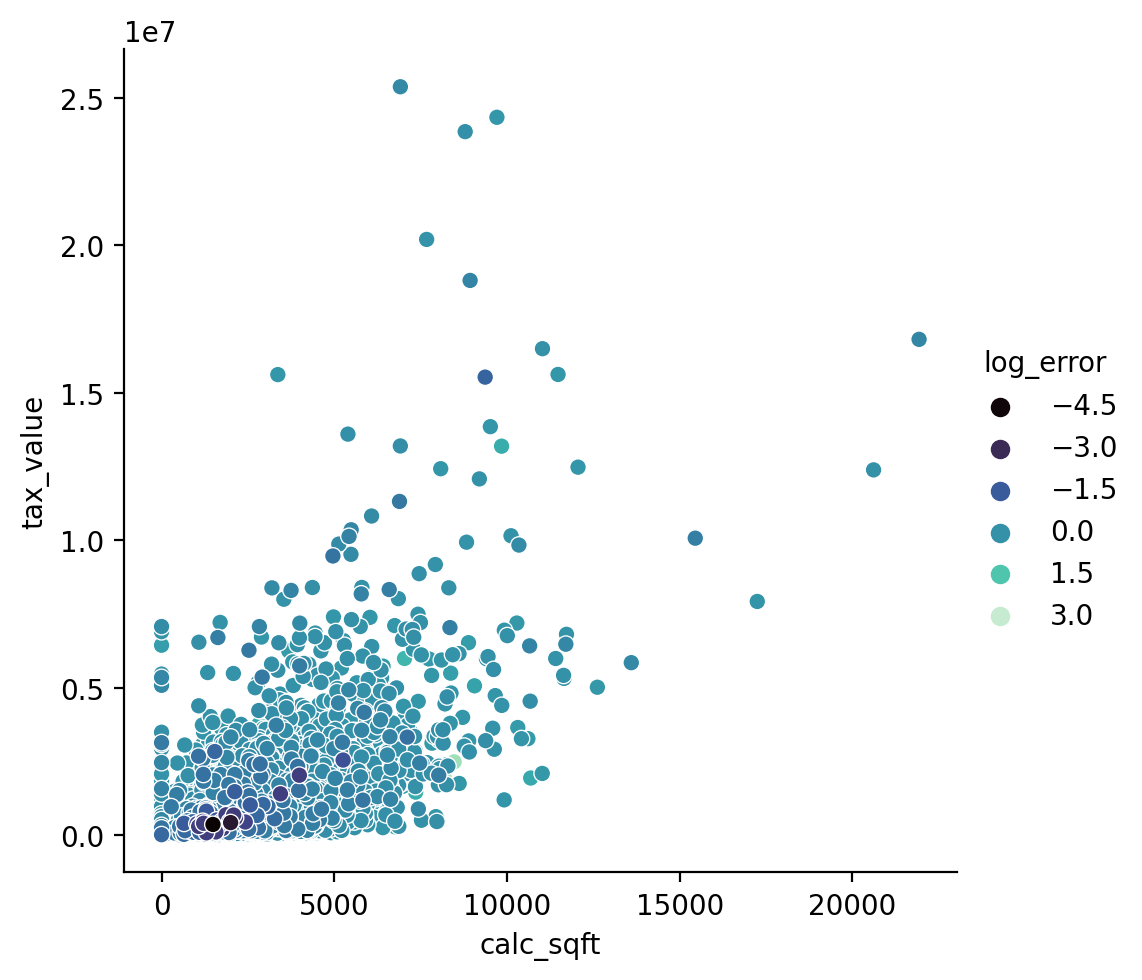

In [11]:
train.log_error = train.log_error.astype('float')
sns.relplot(data=train.sort_values('log_error',ascending=False), x='calc_sqft',y='tax_value',hue='log_error',palette='mako')

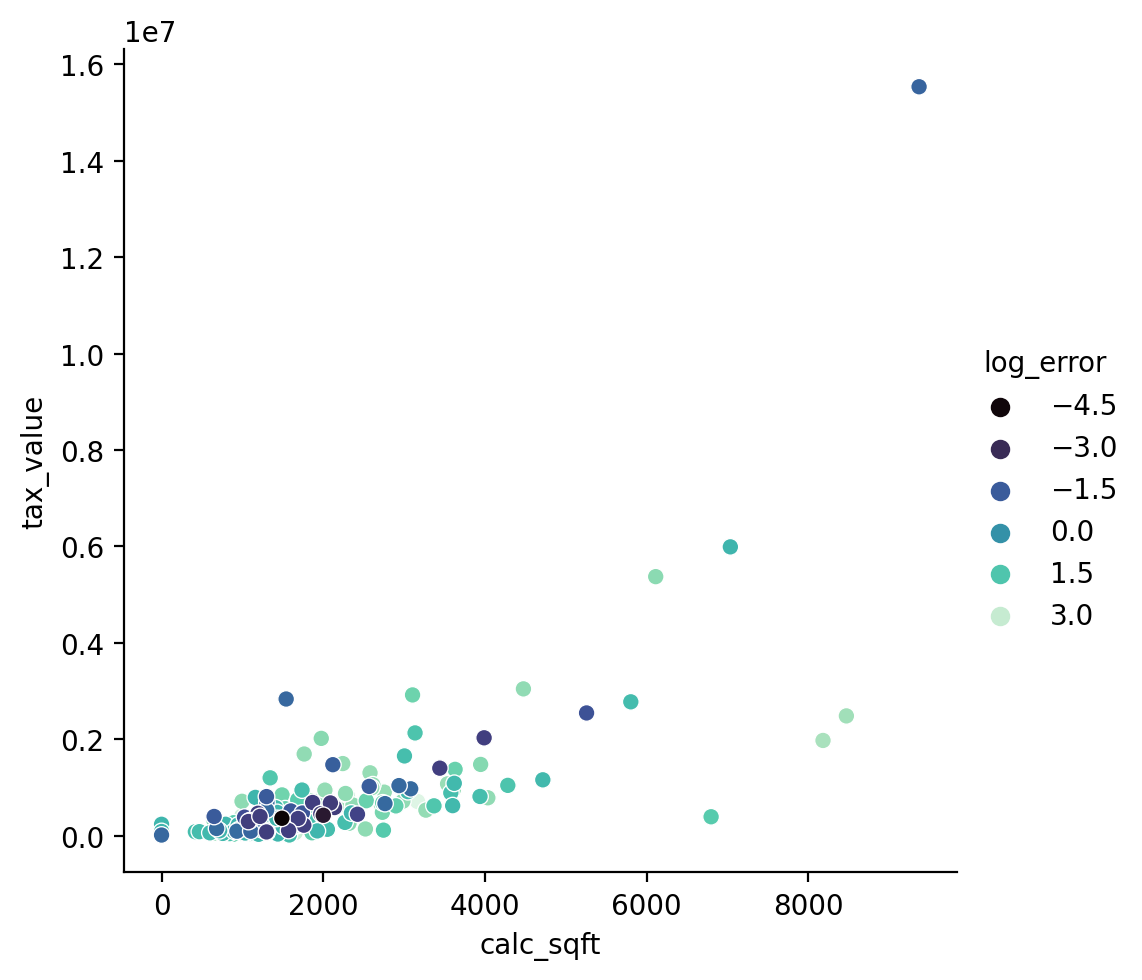

In [17]:
calc = train[((train.log_error >= 1) | (train.log_error<=-1))]
sns.relplot(data=calc.sort_values('log_error',ascending=False), x='calc_sqft',y='tax_value',hue='log_error',palette='mako')

,bed_count
0,2
1,1
2,3
3,3
4,3
...,...
43217,3
43218,3
43219,4
43220,4


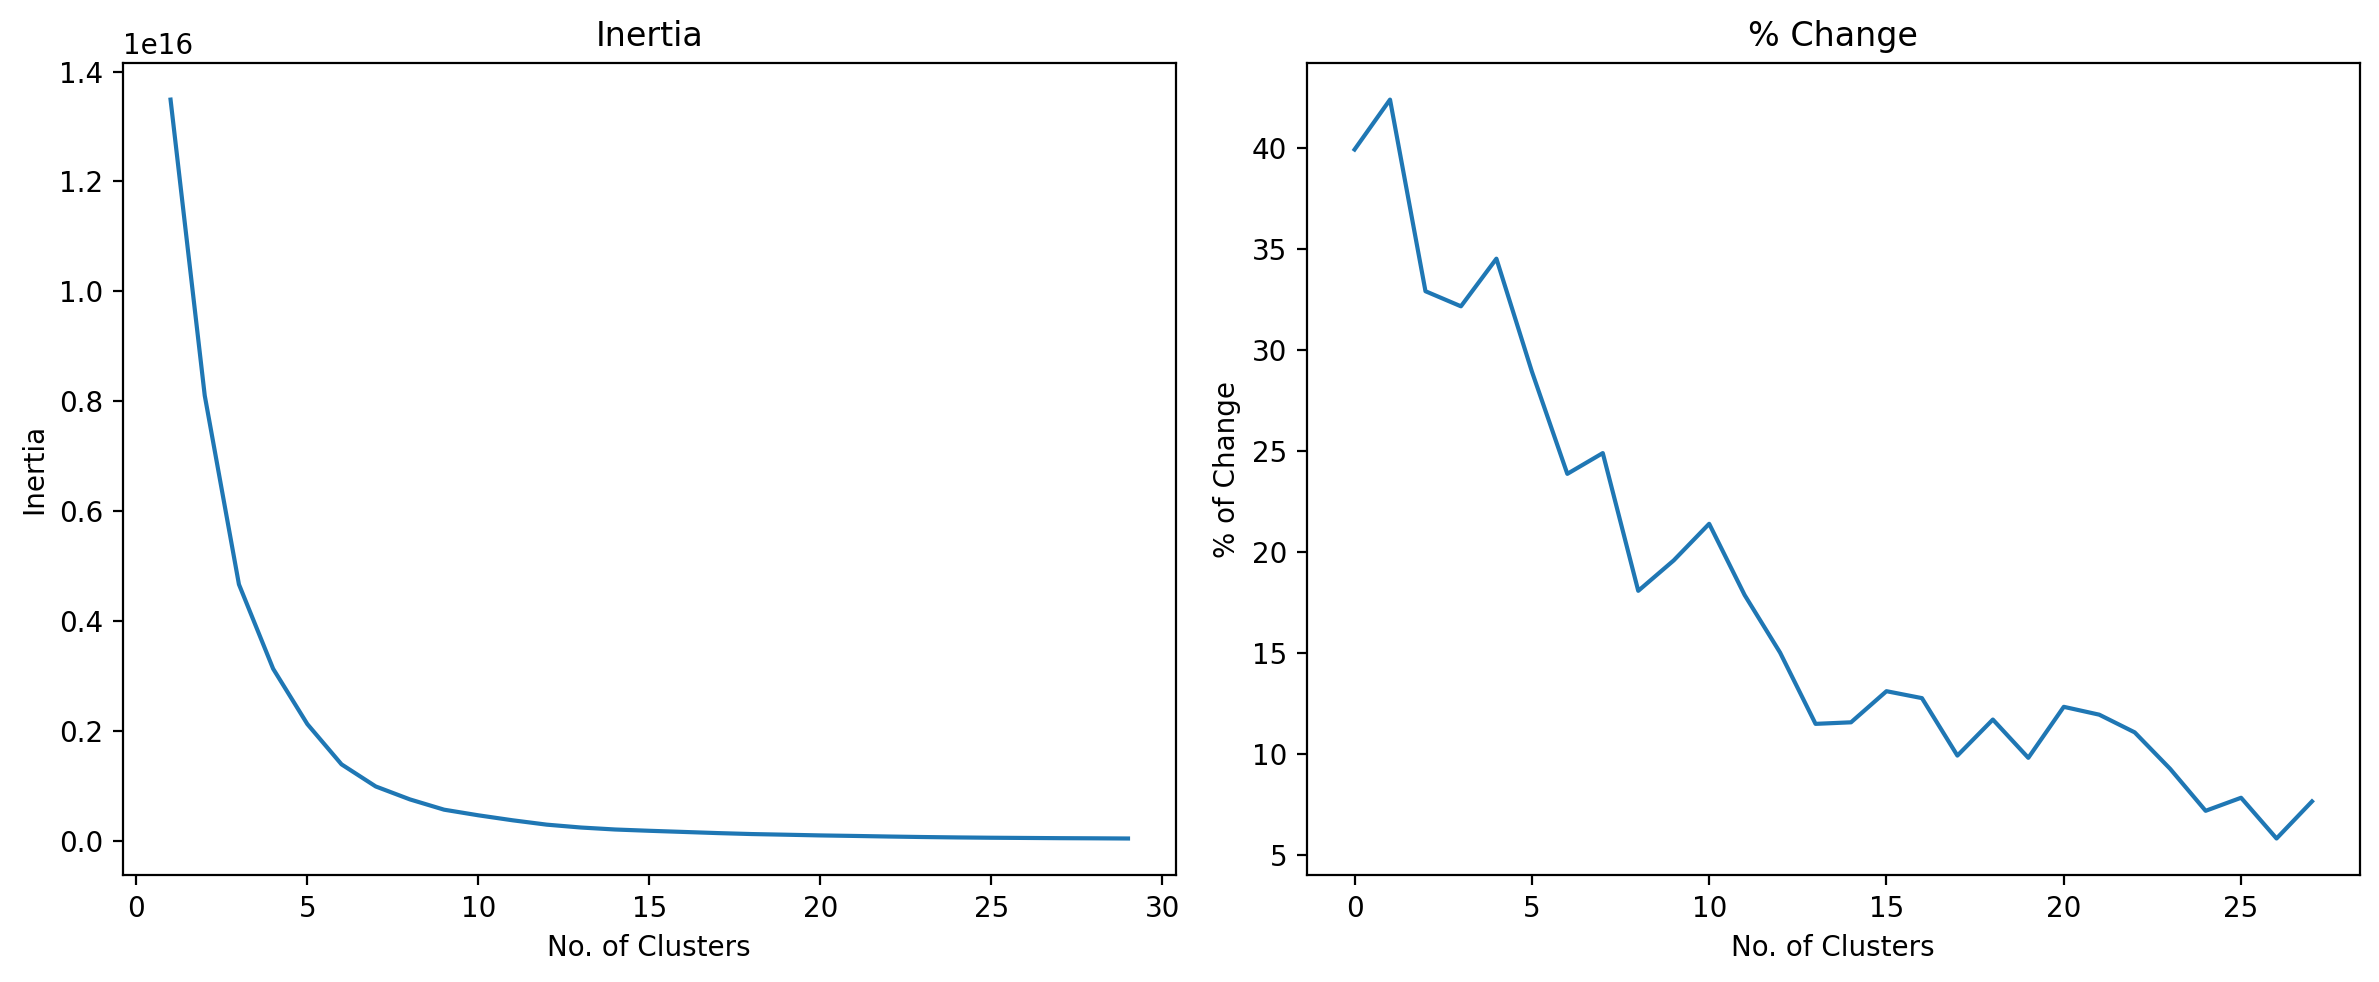

In [ ]:
e.generate_elbow(train[['tax_value','calc_sqft']])

In [ ]:
reload(w)
w.wrangle_zillow().isna().sum()

parcel_id                 0
bath_count                0
bed_count                 0
calc_bath_and_bed         0
fips                      0
fireplace_count           0
garage_car_count          0
latitude                  0
longitude                 0
lot_sqft                  0
pool_count                0
raw_census_tract_block    0
region_id_county          0
room_count                0
assessment_year           0
log_error                 0
transaction_date          0
log_error_outliers        0
outliers                  0
bound_group               0
dtype: int64

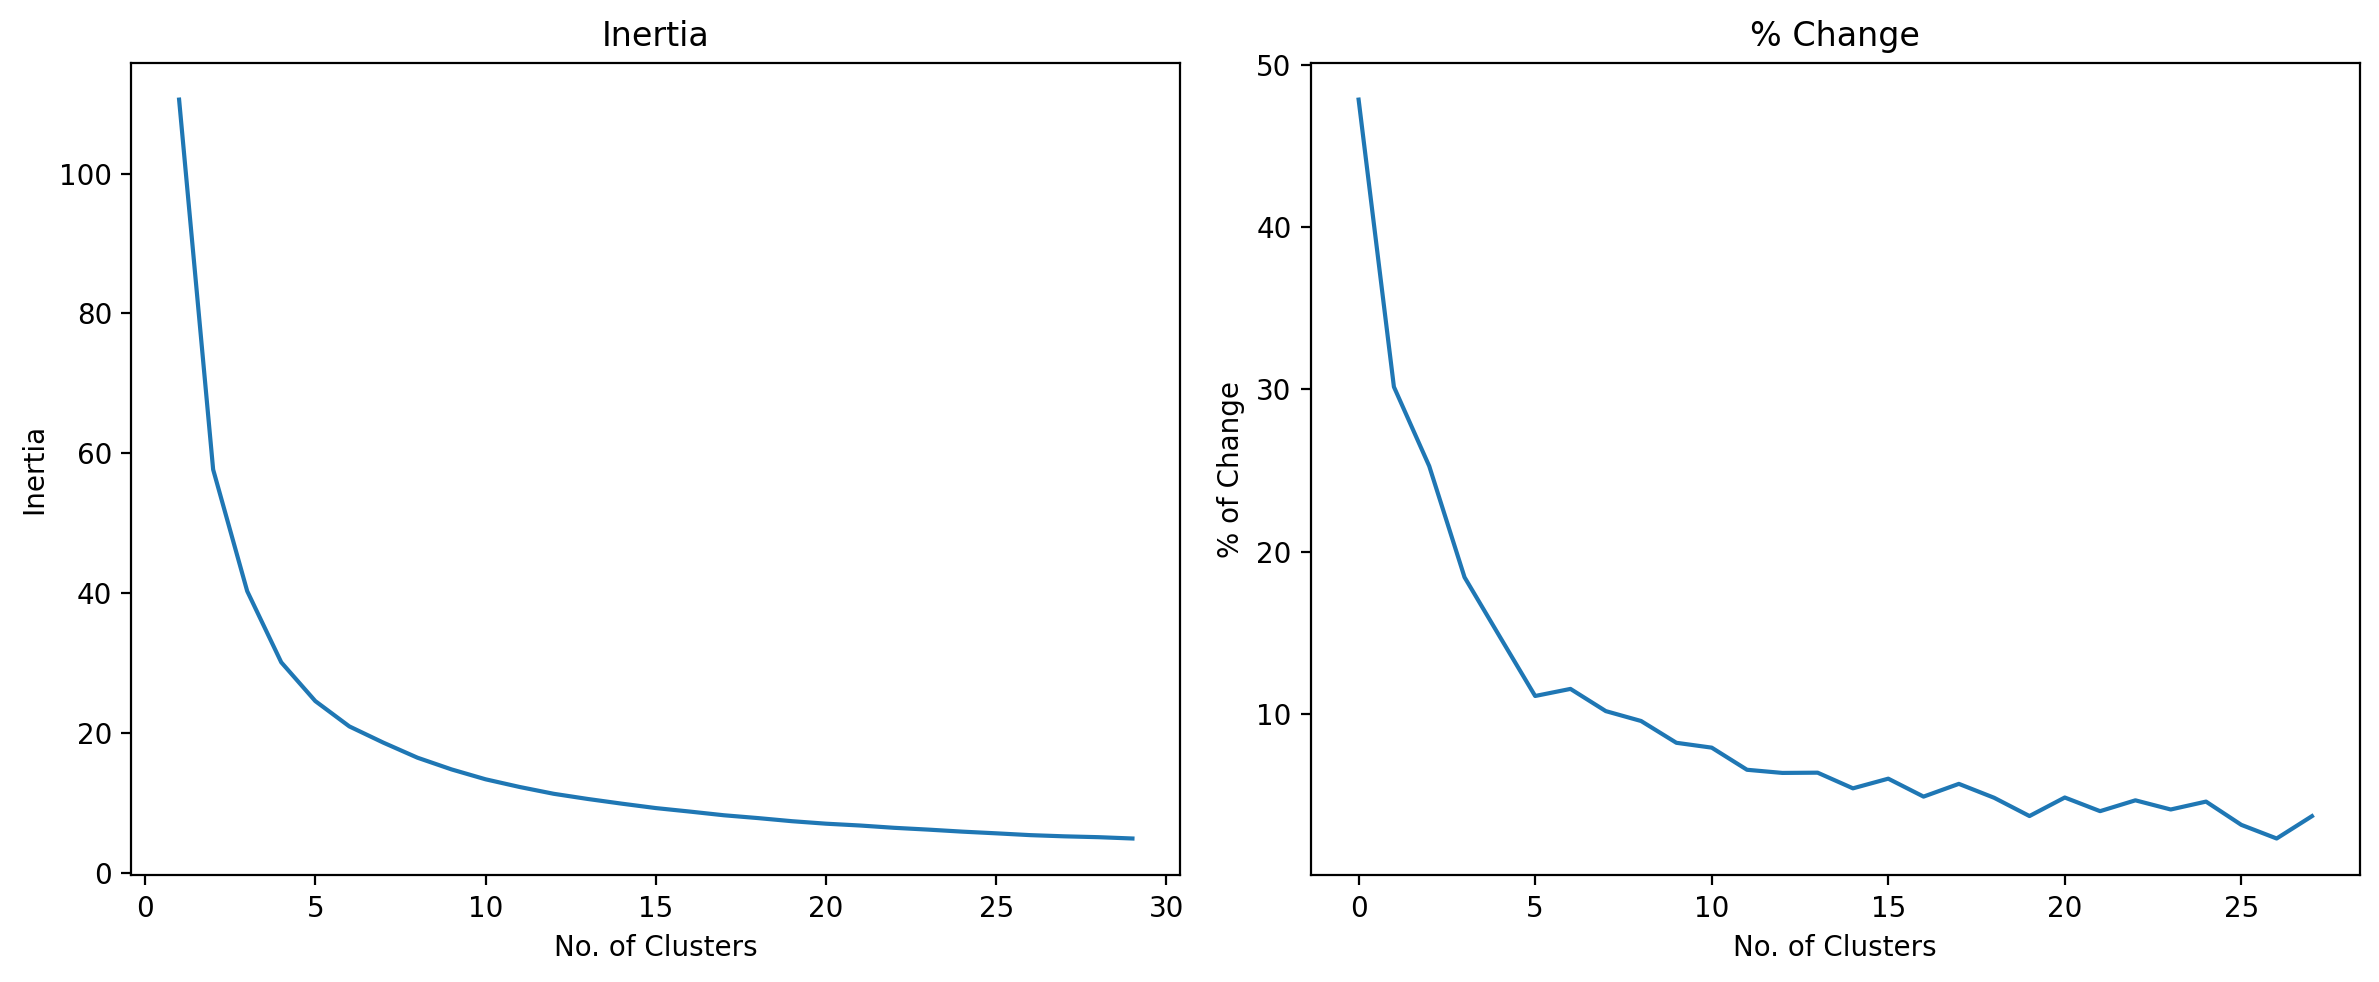

in       42648
above      484
below      198
Name: bound_group, dtype: int64

In [21]:
reload(e)
tax_sqft = w.scale(train,['tax_value','calc_sqft'])
e.generate_elbow(tax_sqft,k_min=1,k_max=30)
train.bound_group.value_counts()

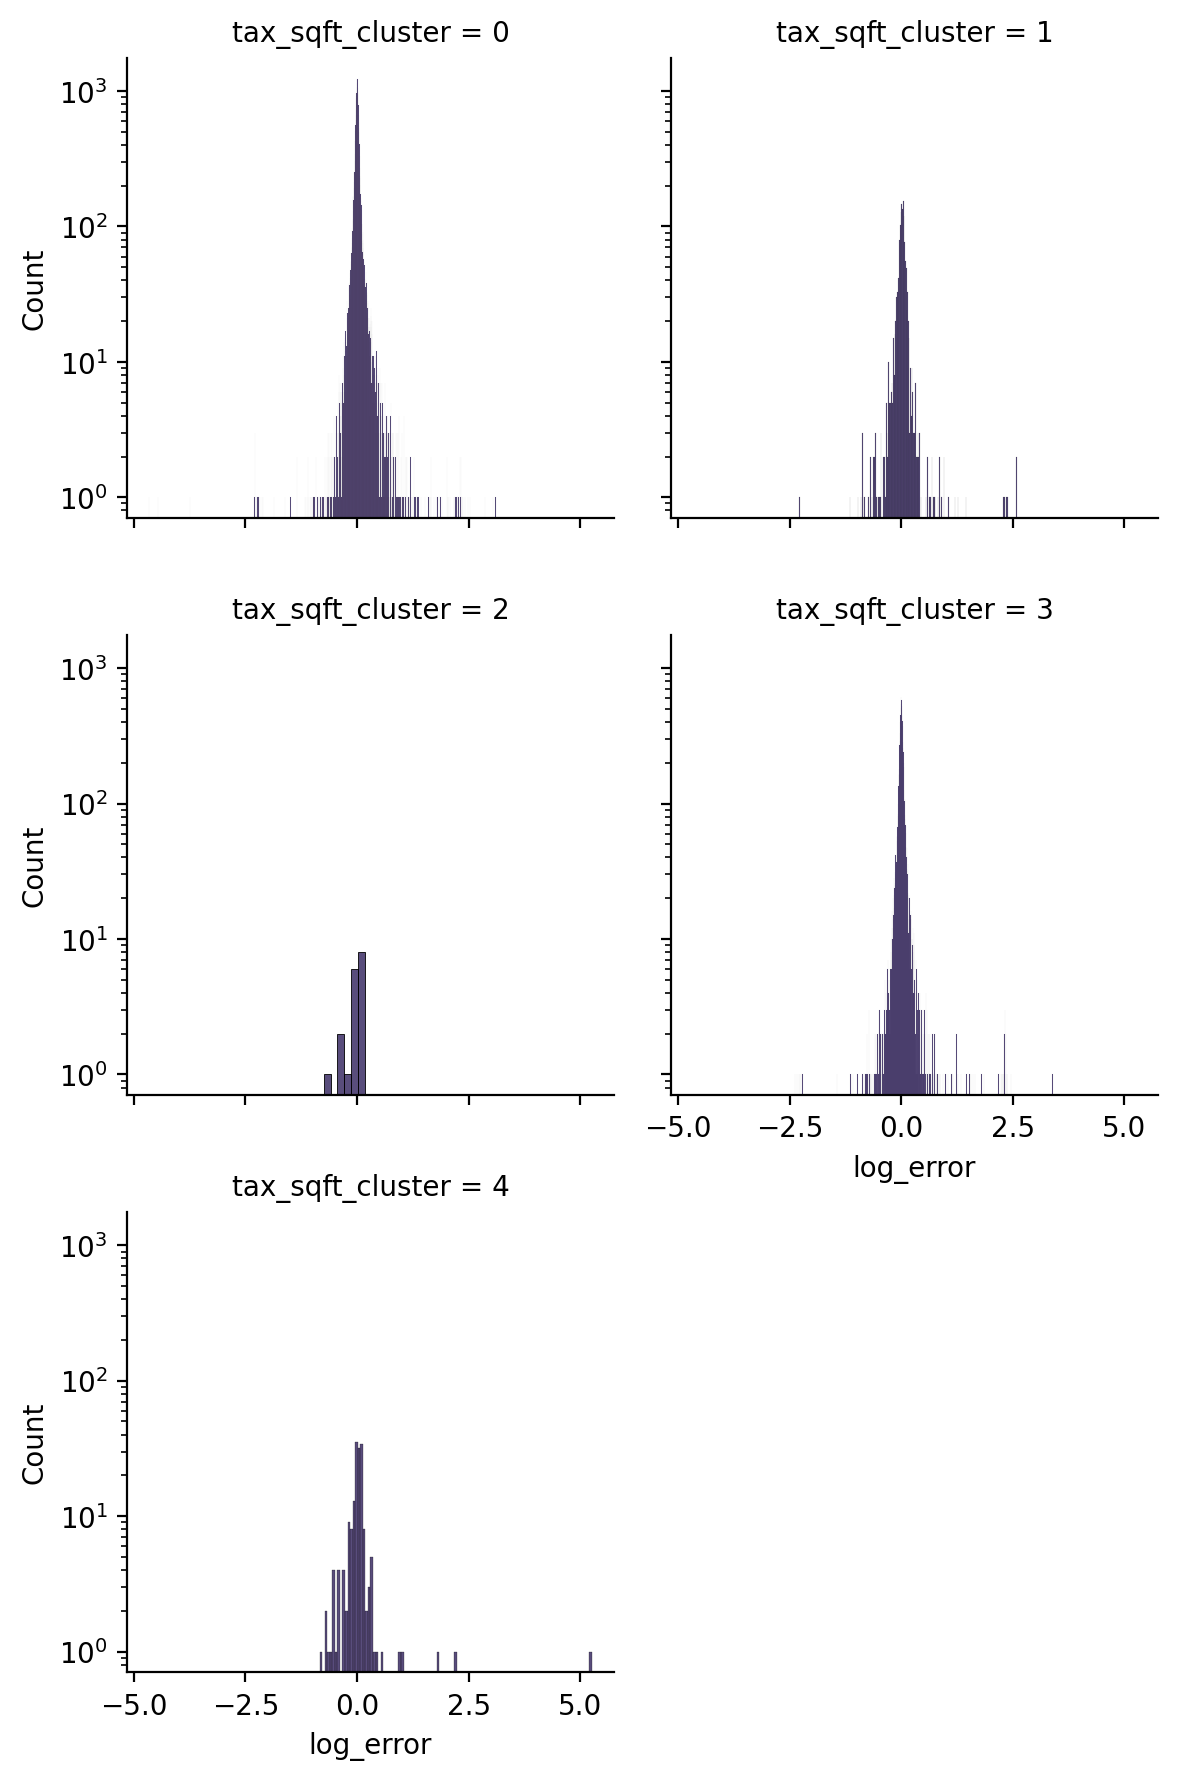

In [33]:
tax_sqft = train[['calc_sqft','tax_value']]
tax_sqft['calc_sqft'] = train['calc_sqft']
tax_sqft['tax_value'] = train['tax_value']
kmeans = KMeans(5,random_state=420)
kmeans.fit(tax_sqft)
tax_sqft['tax_sqft_cluster'] = kmeans.predict(tax_sqft)
tax_sqft['log_error'] = train.log_error
sns.set_palette('magma')
g = sns.FacetGrid(data=tax_sqft,col='tax_sqft_cluster',col_wrap=2,sharey=True,palette='mako').set(yscale='log')
g.map_dataframe(sns.histplot,x='log_error')
plt.show()

Question: is the mean log_error of items clustered by tax_value and calc_sqft significantly different from each other?
$H_0$: $\mu_{taxsqft0} = \mu_{taxsqft1}=$...$\mu_{taxsqft7}$

$H_a$: $\mu_{taxsqft0} \neq \mu_{taxsqft1} \neq $...$\neq \mu_{taxsqft7}$

## Assumptions
- Independent: Yep
- Normal: yes, Central Limit Theorum
- Equal variance:

In [ ]:
train['tax_sqft_cluster'] = tax_sqft.tax_sqft_cluster
train.groupby('tax_sqft_cluster').agg('var').log_error

tax_sqft_cluster
0    0.036410
1    0.025402
2    0.299697
3    0.195313
Name: log_error, dtype: float64

## Nope! so we will use the non-parametric test

In [ ]:
group_list = [train[train.tax_sqft_cluster == x].log_error.to_numpy() for x in range(4)]
t,p = stats.kruskal(group_list[0],group_list[1],group_list[2],group_list[3])
e.t_to_md(t,p)

## t = 7.53317935249534e-08 

 ## p = 35.98774688175805 

## Because t > 0 and $\alpha$ < p,we failed to  reject $H_0$